# Import Packages

In [128]:
import cv2 
import pytesseract
import numpy as np
import json
import re

from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

# Data Labeling

In [468]:
path_to_images = '../data/images/receipts-switzerland/'
image_name = 'swiss_receipt_36.jpeg'

img = cv2.imread(path_to_images + image_name)

## Image text extraction

In order to label the image correctliy for our training with spacy, we first have to convert the image to text using a modern OCR like tesseract.

### Image Preprocessing

To improve the text extraction we do some image preprocessing

In [469]:
def resize(image, scale=1.5):
    height, width = image.shape[:2]
    new_width = int(width * scale)
    new_height = int(height * scale)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

# Image Resizing
# resized = resize(img)

# Grayscale Image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce Noise
# blur = cv2.medianBlur(gray, 3)

# Binarize
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)  # Binarize the image

img = thresh

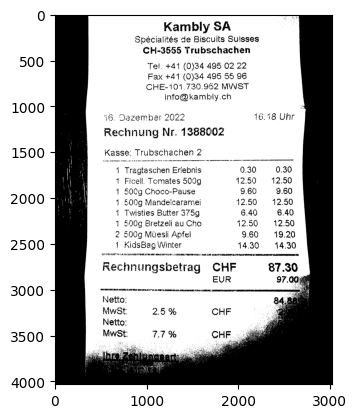

In [470]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Text Extraction

In [471]:
# Blacklist: -c tessedit_char_blacklist="!@%^&*_+=<>?/{}|\\~`£"
# OEM: --oem 3

image_text = pytesseract.image_to_string(img, lang='deu', config='--oem 3 --psm 4 -c tessedit_char_blacklist="!@%^&*_+=<>?/{}|\\~`£"')

image_text

'Kambly SA\nSpecialites de Biscuits Suisses\nCH-3555 Trubschachen\n\nTel. z41 (0)34 495 02 22\n\nFax r41 (0)34 495 55 96\n\nCHE-101.730.952 MWST\ninfo®kambiy.ch\n\n16. Dezember 2022 16.18 Uhr\nRechnung Nr. 1388062\n\nKasse: Trubschachen 2\n\nmm Omen Rise ad „ER DE ren Dub AH. BARS WETTE TE ET SCHE ATERER Ai ARE Pet EEE GI Teru  Rık BENZINER SED HERE Fü, EDER Sainiir inne.\n\n1 Tragtaschen Eriebnis 0.30 0.30\n1 Ficell. Tomates 500g 12.50 12.50\n500g Choco-Pause 9.650 9.50\nA00g Mandeicaramei 12.50 12.50\nTwisties Butter 375g 5.40 6.40\nN0g Bretzeli au Cho 12.50 12.50\n060g Müessli Apfel 9.60 19.20\nKiülsBag Winter 14.30 14.30\nRechnungsbefrag CHF 87 ‚So\nEUR\n\nan e BAAR MER ERTEILEN U ST SUR 5 EA NERERETE  EAEALEESETNDLLIERERTRTD EENERRSTH\n\nNetto:\nMwSt: 2.5\nNetto:\nMwst: TTR\n\n'

In [472]:
print(image_text)

Kambly SA
Specialites de Biscuits Suisses
CH-3555 Trubschachen

Tel. z41 (0)34 495 02 22

Fax r41 (0)34 495 55 96

CHE-101.730.952 MWST
info®kambiy.ch

16. Dezember 2022 16.18 Uhr
Rechnung Nr. 1388062

Kasse: Trubschachen 2

mm Omen Rise ad „ER DE ren Dub AH. BARS WETTE TE ET SCHE ATERER Ai ARE Pet EEE GI Teru  Rık BENZINER SED HERE Fü, EDER Sainiir inne.

1 Tragtaschen Eriebnis 0.30 0.30
1 Ficell. Tomates 500g 12.50 12.50
500g Choco-Pause 9.650 9.50
A00g Mandeicaramei 12.50 12.50
Twisties Butter 375g 5.40 6.40
N0g Bretzeli au Cho 12.50 12.50
060g Müessli Apfel 9.60 19.20
KiülsBag Winter 14.30 14.30
Rechnungsbefrag CHF 87 ‚So
EUR

an e BAAR MER ERTEILEN U ST SUR 5 EA NERERETE  EAEALEESETNDLLIERERTRTD EENERRSTH

Netto:
MwSt: 2.5
Netto:
Mwst: TTR




## Entity Extraction

In [473]:
items = [
    {
        'item': '1 Tragtaschen Eriebnis 0.30 0.30',
        'quantity': '1',
        'name': 'Tragtaschen Eriebnis',
        'price': '0.30'
    },
    {
        'item': '1 Ficell. Tomates 500g 12.50 12.50',
        'quantity': '1',
        'name': 'Ficell. Tomates 500g',
        'price': '12.50'
    },
    {
        'item': '500g Choco-Pause 9.650 9.50',
        'quantity': None,
        'name': '500g Choco-Pause',
        'price': '9.50'
    },
    {
        'item': 'A00g Mandeicaramei 12.50 12.50',
        'quantity': None,
        'name': 'A00g Mandeicaramei',
        'price': '12.50'
    },
    {
        'item': 'Twisties Butter 375g 5.40 6.40',
        'quantity': None,
        'name': 'Twisties Butter 375g',
        'price': '6.40'
    },
    {
        'item': 'N0g Bretzeli au Cho 12.50 12.50',
        'quantity': None,
        'name': 'N0g Bretzeli au Cho',
        'price': '12.50'
    },
    {
        'item': '060g Müessli Apfel 9.60 19.20',
        'quantity': None,
        'name': '060g Müessli Apfel',
        'price': '19.20'
    },
    {
        'item': 'KiülsBag Winter 14.30 14.30',
        'quantity': None,
        'name': 'KiülsBag Winter',
        'price': '14.30'
    },
]



entities = []
for entity in items:
    # item
    item = entity['item']
    item_starting_index = image_text.index(item)
    item_end_index = item_starting_index + len(item)
    entities.append([item_starting_index, item_end_index, "RECEIPT_ITEM"])
    print(f'\nItem: "{item}" starts at: {item_starting_index}, ends at: {item_end_index}')
    
    # quantity
    if entity['quantity'] is not None:
        item_quantity = entity['quantity']
        starting_index = item_starting_index + item.index(item_quantity)
        end_index = starting_index + len(item_quantity)
        entities.append([starting_index, end_index, "RECEIPT_ITEM_QUANTITY"])
        print(f'\tQuantity: "{item_quantity}" starts at: {starting_index}, ends at: {end_index}')
        
    # name
    if entity['name'] is not None:
        item_name = entity['name']
        starting_index = item_starting_index + item.index(item_name)
        end_index = starting_index + len(item_name)
        entities.append([starting_index, end_index, "RECEIPT_ITEM_NAME"])
        print(f'\tName: "{item_name}" starts at: {starting_index}, ends at: {end_index}')
        
    # price
    if entity['price'] is not None:
        item_price = entity['price']
        starting_indices = [item_starting_index + i.start() for i in re.finditer(item_price, item)]
        end_indices = [start + len(item_price) for start in starting_indices]
        
        if len(starting_indices) != 1:
            print('WARNING! Found Multiple Prices! Delete the wrong ones out of the array!')
        for start, end in zip(starting_indices, end_indices):
            entities.append([start, end, "RECEIPT_ITEM_PRICE"])
            print(f'\tPrice: "{item_price}" starts at: {start}, ends at: {end}')


Item: "1 Tragtaschen Eriebnis 0.30 0.30" starts at: 359, ends at: 391
	Quantity: "1" starts at: 359, ends at: 360
	Name: "Tragtaschen Eriebnis" starts at: 361, ends at: 381
WARNING! Found Multiple Prices! Delete the wrong ones out of the array!
	Price: "0.30" starts at: 382, ends at: 386
	Price: "0.30" starts at: 387, ends at: 391

Item: "1 Ficell. Tomates 500g 12.50 12.50" starts at: 392, ends at: 426
	Quantity: "1" starts at: 392, ends at: 393
	Name: "Ficell. Tomates 500g" starts at: 394, ends at: 414
WARNING! Found Multiple Prices! Delete the wrong ones out of the array!
	Price: "12.50" starts at: 415, ends at: 420
	Price: "12.50" starts at: 421, ends at: 426

Item: "500g Choco-Pause 9.650 9.50" starts at: 427, ends at: 454
	Name: "500g Choco-Pause" starts at: 427, ends at: 443
	Price: "9.50" starts at: 450, ends at: 454

Item: "A00g Mandeicaramei 12.50 12.50" starts at: 455, ends at: 485
	Name: "A00g Mandeicaramei" starts at: 455, ends at: 473
WARNING! Found Multiple Prices! Delet

Check the output of the entity extraction and make sure everything is correct. The indexes could be wrong because of the string.index() only returns the first match.

In [474]:
entities

[[359, 391, 'RECEIPT_ITEM'],
 [359, 360, 'RECEIPT_ITEM_QUANTITY'],
 [361, 381, 'RECEIPT_ITEM_NAME'],
 [382, 386, 'RECEIPT_ITEM_PRICE'],
 [387, 391, 'RECEIPT_ITEM_PRICE'],
 [392, 426, 'RECEIPT_ITEM'],
 [392, 393, 'RECEIPT_ITEM_QUANTITY'],
 [394, 414, 'RECEIPT_ITEM_NAME'],
 [415, 420, 'RECEIPT_ITEM_PRICE'],
 [421, 426, 'RECEIPT_ITEM_PRICE'],
 [427, 454, 'RECEIPT_ITEM'],
 [427, 443, 'RECEIPT_ITEM_NAME'],
 [450, 454, 'RECEIPT_ITEM_PRICE'],
 [455, 485, 'RECEIPT_ITEM'],
 [455, 473, 'RECEIPT_ITEM_NAME'],
 [474, 479, 'RECEIPT_ITEM_PRICE'],
 [480, 485, 'RECEIPT_ITEM_PRICE'],
 [486, 516, 'RECEIPT_ITEM'],
 [486, 506, 'RECEIPT_ITEM_NAME'],
 [512, 516, 'RECEIPT_ITEM_PRICE'],
 [517, 548, 'RECEIPT_ITEM'],
 [517, 536, 'RECEIPT_ITEM_NAME'],
 [537, 542, 'RECEIPT_ITEM_PRICE'],
 [543, 548, 'RECEIPT_ITEM_PRICE'],
 [549, 578, 'RECEIPT_ITEM'],
 [549, 567, 'RECEIPT_ITEM_NAME'],
 [573, 578, 'RECEIPT_ITEM_PRICE'],
 [579, 606, 'RECEIPT_ITEM'],
 [579, 594, 'RECEIPT_ITEM_NAME'],
 [595, 600, 'RECEIPT_ITEM_PRICE'],


### !!(OPTIONAL)!! Fix if neccessary

To fix the indexes copy the part from above and overwrite the entites array with the correct indicies

In [475]:
## WARNING: only when necessary

entities = [[359, 391, 'RECEIPT_ITEM'],
 [359, 360, 'RECEIPT_ITEM_QUANTITY'],
 [361, 381, 'RECEIPT_ITEM_NAME'],
 [387, 391, 'RECEIPT_ITEM_PRICE'],
 [392, 426, 'RECEIPT_ITEM'],
 [392, 393, 'RECEIPT_ITEM_QUANTITY'],
 [394, 414, 'RECEIPT_ITEM_NAME'],
 [421, 426, 'RECEIPT_ITEM_PRICE'],
 [427, 454, 'RECEIPT_ITEM'],
 [427, 443, 'RECEIPT_ITEM_NAME'],
 [450, 454, 'RECEIPT_ITEM_PRICE'],
 [455, 485, 'RECEIPT_ITEM'],
 [455, 473, 'RECEIPT_ITEM_NAME'],
 [480, 485, 'RECEIPT_ITEM_PRICE'],
 [486, 516, 'RECEIPT_ITEM'],
 [486, 506, 'RECEIPT_ITEM_NAME'],
 [512, 516, 'RECEIPT_ITEM_PRICE'],
 [517, 548, 'RECEIPT_ITEM'],
 [517, 536, 'RECEIPT_ITEM_NAME'],
 [543, 548, 'RECEIPT_ITEM_PRICE'],
 [549, 578, 'RECEIPT_ITEM'],
 [549, 567, 'RECEIPT_ITEM_NAME'],
 [573, 578, 'RECEIPT_ITEM_PRICE'],
 [579, 606, 'RECEIPT_ITEM'],
 [579, 594, 'RECEIPT_ITEM_NAME'],
 [601, 606, 'RECEIPT_ITEM_PRICE']]

## Save Image Reference, Extracted Text & Entities to Dataset

Load the already existing training data. Use a separate File for different types of receipts or new labeling entities.

In [476]:
try:
    # TODO: use different file when starting new labling session and update bottom write execution
    file = open('../data/datasets/ner-swiss-receipts.json', 'r')
except FileNotFoundError:
    print('file not found')
    data = []
else:
    with file:
        data = json.load(file)

In [477]:
new_data_entry = {
    "image_name": image_name,
    "text": image_text,
    "entities": entities,
}

new_data_entry

{'image_name': 'swiss_receipt_36.jpeg',
 'text': 'Kambly SA\nSpecialites de Biscuits Suisses\nCH-3555 Trubschachen\n\nTel. z41 (0)34 495 02 22\n\nFax r41 (0)34 495 55 96\n\nCHE-101.730.952 MWST\ninfo®kambiy.ch\n\n16. Dezember 2022 16.18 Uhr\nRechnung Nr. 1388062\n\nKasse: Trubschachen 2\n\nmm Omen Rise ad „ER DE ren Dub AH. BARS WETTE TE ET SCHE ATERER Ai ARE Pet EEE GI Teru  Rık BENZINER SED HERE Fü, EDER Sainiir inne.\n\n1 Tragtaschen Eriebnis 0.30 0.30\n1 Ficell. Tomates 500g 12.50 12.50\n500g Choco-Pause 9.650 9.50\nA00g Mandeicaramei 12.50 12.50\nTwisties Butter 375g 5.40 6.40\nN0g Bretzeli au Cho 12.50 12.50\n060g Müessli Apfel 9.60 19.20\nKiülsBag Winter 14.30 14.30\nRechnungsbefrag CHF 87 ‚So\nEUR\n\nan e BAAR MER ERTEILEN U ST SUR 5 EA NERERETE  EAEALEESETNDLLIERERTRTD EENERRSTH\n\nNetto:\nMwSt: 2.5\nNetto:\nMwst: TTR\n\n',
 'entities': [[359, 391, 'RECEIPT_ITEM'],
  [359, 360, 'RECEIPT_ITEM_QUANTITY'],
  [361, 381, 'RECEIPT_ITEM_NAME'],
  [387, 391, 'RECEIPT_ITEM_PRICE'],
  [

In [478]:
data.append(new_data_entry)

# convert into JSON:
json_data = json.dumps(data)

# TODO: use different file when starting new labling session and update bottom write execution
with open("../data/datasets/ner-swiss-receipts.json", "w+") as outfile:
    outfile.write(json_data)
    
print('added training data')

added training data
